# Question 1

In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

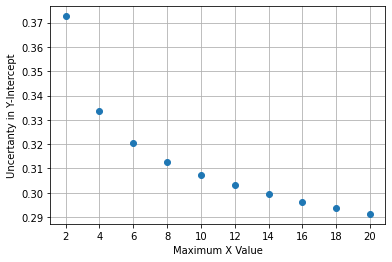

In [2]:
x_low = 0.5
x_high_array = numpy.linspace(2,20,10)
normal_dist = stats.norm.rvs(size=10,loc=0,scale=.2)

intercept_uncertanty = []
for x_high in x_high_array:
    x_vals = numpy.linspace(x_low,x_high,10)
    y_vals = x_vals + normal_dist

    errors = numpy.array([0.1+ 1.5/numpy.abs(x_vals[i]) for i in range(10)])
    init_vals = [0.0 for x in range(2)]
    popt, pcov = curve_fit(fitfunction,x_vals,y_vals,p0=init_vals,sigma=errors)
    perr = numpy.sqrt(numpy.diag(pcov))
    intercept_uncertanty.append(perr[0])

plt.plot(x_high_array, intercept_uncertanty, 'o')
plt.xlabel('Maximum X Value')
plt.ylabel('Uncertanty in Y-Intercept')
plt.grid()
plt.xticks(x_high_array)
plt.show()

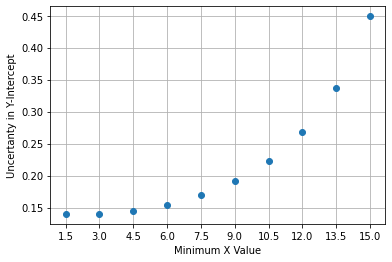

In [3]:
x_high = 20
x_low_array = numpy.linspace(1.5,15,10)
normal_dist = stats.norm.rvs(size=10,loc=0,scale=.2)

intercept_uncertanty = []
for x_low in x_low_array:
    x_vals = numpy.linspace(x_low,x_high,10)
    y_vals = x_vals + normal_dist

    errors = numpy.array([0.1+ 1.5/numpy.abs(x_vals[i]) for i in range(10)])
    init_vals = [0.0 for x in range(2)]
    popt, pcov = curve_fit(fitfunction,x_vals,y_vals,p0=init_vals,sigma=errors)
    perr = numpy.sqrt(numpy.diag(pcov))
    intercept_uncertanty.append(perr[0])

plt.plot(x_low_array, intercept_uncertanty, 'o')
plt.xlabel('Minimum X Value')
plt.ylabel('Uncertanty in Y-Intercept')
plt.grid()
plt.xticks(x_low_array)
plt.show()

These two plots suggest that the optimal experiment design (in the case where uncertantly increases at small X values) is to measure more data at larger X values. This is at least semi-intuative, as there is less uncertanty at these larger x values and the further out you take data the longer "lever arm" you have to nail down the y-intercept.

# Question 2

In [1]:
import datetime
import numpy
import pandas as pd
import matplotlib.pyplot as plt

class Sun:
    def getSunriseTime( self, coords ):
        return self.calcSunTime( coords, True )
    def getSunsetTime( self, coords ):
        return self.calcSunTime( coords, False )
    def getCurrentUTC( self ):
        now = datetime.datetime.now()
        return [ now.day, now.month, now.year ]
    def calcSunTime( self, coords, isRiseTime, zenith = 90.8 ):
        day, month, year = self.getCurrentUTC()
        longitude = coords['longitude']
        latitude = coords['latitude']
        TO_RAD = numpy.pi/180
        N = numpy.array([i for i in range(1,366)])
        lngHour = longitude / 15
        if isRiseTime:
            t = N + ((6 - lngHour) / 24)
        else:
            t = N + ((18 - lngHour) / 24)
        M = (0.9856 * t) - 3.289
        L = M + (1.916 * numpy.sin(TO_RAD*M)) + (0.020 * numpy.sin(TO_RAD * 2 * M)) + 282.634
        L = self.forceRange( L, 360 )
        RA = (1/TO_RAD) * numpy.arctan(0.91764 * numpy.tan(TO_RAD*L))
        RA = self.forceRange( RA, 360 )
        Lquadrant  = (numpy.floor( L/90)) * 90
        RAquadrant = (numpy.floor(RA/90)) * 90
        RA = RA + (Lquadrant - RAquadrant)
        RA = RA / 15
        sinDec = 0.39782 * numpy.sin(TO_RAD*L)
        cosDec = numpy.cos(numpy.arcsin(sinDec))
        cosH = (numpy.cos(TO_RAD*zenith) - (sinDec * numpy.sin(TO_RAD*latitude))) / (cosDec * numpy.cos(TO_RAD*latitude))
        if isRiseTime:
            H = 360 - (1/TO_RAD) * numpy.arccos(cosH)
        else: 
            H = (1/TO_RAD) * numpy.arccos(cosH)

        H = H / 15
        T = H + RA - (0.06571 * t) - 6.622
        UT = T - lngHour
        UT = self.forceRange( UT, 24)
        return {
            'status': True,
            'decimal': UT
        }
    def forceRange( self, v, max ):
        for i in range(len(v)):
            if v[i] < 0:
                v[i] = v[i] + max
            elif v[i] >= max:
                v[i] = v[i] - max
        return v

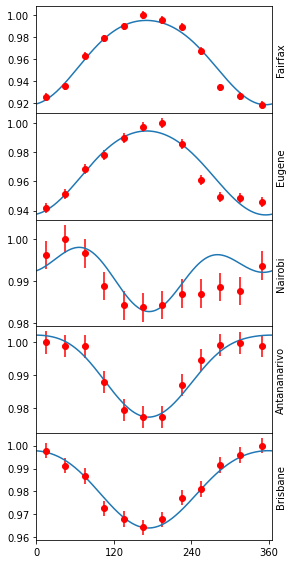

In [2]:
daysPerYear = 365.256363
tiltAngle = -23.44*numpy.pi/180.0
dayOfYear = numpy.array([i for i in range(1,366)])

rES=1.0-0.01672*numpy.cos(2.0*numpy.pi/daysPerYear*(dayOfYear-4))
relPower=1/rES**2

angle = tiltAngle*numpy.cos(2.0*numpy.pi/daysPerYear*(dayOfYear+10))

locations = ['Fairfax', 'Eugene', 'Nairobi', 'Antananarivo', 'Brisbane'] 
latitude = [38.8462, 44.0521, -1.2921, -18.8792, -27.4698]
longitude = [77.3064, 123.0868, 36.8219, 47.5079, 153.0251]

angles = [(i * numpy.pi/180.0 - angle) for i in latitude]

day_length_corrections = []
for i in range(0,5):
    coords = {'longitude': longitude[i], 'latitude': latitude[i]}
    sun = Sun()
    sunrise = sun.getSunriseTime(coords)['decimal']
    sunset = sun.getSunsetTime(coords)['decimal']
    dayLength = sun.getSunsetTime(coords)['decimal']-sun.getSunriseTime(coords)['decimal']
    for i in range(len(dayLength)):
        if dayLength[i]<0:
            dayLength[i] = dayLength[i]+24
    day_length_corrections.append(dayLength/12.0)

temp_theory = numpy.cos(angles)*relPower*numpy.sqrt(day_length_corrections)

# All 2019 monthly average temperature data is taken from wunderground.com (Celsius).
experimental_temps = []
experimental_temps.append(numpy.array([3, 5.09, 7.97, 16.39, 21.13, 24.37, 27.53, 26.15, 24.27, 17.67, 7.68, 5.34]) + 273.15) # Fairfax
experimental_temps.append(numpy.array([4.62, 3.45, 6.31, 11.36, 14.14, 17.48,	19.75, 20.56, 16.31, 9.02, 5.72, 5.38]) + 273.15) # Eugene
experimental_temps.append(numpy.array([21.35, 22.11, 23.23, 22.21, 19.92, 18.56, 18.42, 18.58, 19.38, 19.38, 19.84, 19.58]) + 273.15) # Nairobi
experimental_temps.append(numpy.array([21.56, 21.86, 21.54, 21.5, 18.32, 15.83, 15.21, 15.17, 18.02, 20.27, 21.63, 21.79]) + 273.15) # Antananarivo
experimental_temps.append(numpy.array([25.99, 25.34, 23.39, 22.02, 17.8, 16.4, 15.32, 16.34, 19.18, 20.31, 23.44, 24.75]) + 273.15) # Brisbane

month = numpy.array([(15+30*(i-2)) for i in range(1,13)])
for i in range(len(month)):
    if month[i]<0:
        month[i]=month[i]+365

# Assume that the temperature is only accurate within 1 degree.
error = numpy.array([1 for i in range(12)])

# Define the factors that we use to fit the theoretical curve to the experimental temperature data. 
fitting_factors = [
                   [8,0.99],
                   [12,0.992],
                   [9,0.996],
                   [16,0.997],
                   [16,0.991]
]

# Plot the results.
fig, axs = plt.subplots(5, 1, figsize=(4,8), sharex=True)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
for i in range(5):

    axs[i].plot(dayOfYear, (temp_theory[i]-1)/fitting_factors[i][0]+fitting_factors[i][1])
    axs[i].errorbar(month, experimental_temps[i]/max(experimental_temps[i]), fmt='ro', yerr=error/max(experimental_temps[i]))
    axs[i].set_xlim(0,365)
    axs[i].set_xticks(numpy.linspace(0, 360, 4))
    axs[i].yaxis.set_label_position("right")
    axs[i].set_ylabel(locations[i])

At all locations there seems to be some amount of deviation from the theory in the latter months of 2019. This is especially visible in the Nairobi plot, where Sept-Nov temperatures are clearly not aligned with theory. This may be expected as our model does not account for many things that affect climate such as proximity to water and pollution.

# Question 3

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def theoryfitfunction1(xdata,*paramlist):
    
    M=1.35928 # large mass
    m=0.72705 # small mass
    Mbar=2.90 # mass of bar (with small and large masses removed)
    D=0.9986 # distance between knife-edge pivot points
    L=1.523  # length of bar
    
    g = paramlist[0]
    fudge_factor=0.00292

    RM = 0.04753
    Rm = 0.03498
    offsetM = 0.0135
    offsetm = 0.0104
    l1=D/2.0+RM+offsetM
    
    l2 = D/2.0+Rm+offsetm+xdata/100.0+fudge_factor
    x=(M*l1-m*l2)/(M+m+Mbar)
    
    h2=D/2.0+x
    h1=D/2.0-x
    Icm=1.0/12.0*Mbar*L*L+Mbar*x*x+M*(l1-x)*(l1-x)+m*(l2+x)*(l2+x)+1/2.0*m*Rm**2 + 1.0/2*M*RM**2
    rhs=Icm/(M+m+Mbar)
    
    t1 = 2*numpy.pi*numpy.sqrt((h1*h1+rhs)/(g*h1))
    t2 = 2*numpy.pi*numpy.sqrt((h2*h2+rhs)/(g*h2))
    
    return t1

def theoryfitfunction2(xdata,*paramlist):
    
    M=1.35928 # large mass
    m=0.72705 # small mass
    Mbar=2.90 # mass of bar (with small and large masses removed)
    D=0.9986 # distance between knife-edge pivot points
    L=1.523  # length of bar
    
    g = paramlist[0]
    fudge_factor=0.00292

    RM = 0.04753
    Rm = 0.03498
    offsetM = 0.0135
    offsetm = 0.0104
    l1=D/2.0+RM+offsetM
    
    l2 = D/2.0+Rm+offsetm+xdata/100.0+fudge_factor
    x=(M*l1-m*l2)/(M+m+Mbar)
    
    h2=D/2.0+x
    h1=D/2.0-x
    Icm=1.0/12.0*Mbar*L*L+Mbar*x*x+M*(l1-x)*(l1-x)+m*(l2+x)*(l2+x)+1/2.0*m*Rm**2 + 1.0/2*M*RM**2
    rhs=Icm/(M+m+Mbar)
    
    t1 = 2*numpy.pi*numpy.sqrt((h1*h1+rhs)/(g*h1))
    t2 = 2*numpy.pi*numpy.sqrt((h2*h2+rhs)/(g*h2))
    
    return t2
    
xpos = numpy.array([1.045, 2.044, 3.012, 4.012, 5.061, 6.011, 7.044])
dxpos = numpy.array([0.003 for i in range(len(xpos))])

prefix = 'https://raw.githubusercontent.com/brash99/phys421/master/JupyterNotebooks/KaterPendulum/data/scan2/kater_2_run'
suffix = '.txt'

tup = []
tdown = []
dtup = []
dtdown = []

Up: g = 9.7915 +/- 0.0074
Down: g = 9.7971 +/- 0.0073


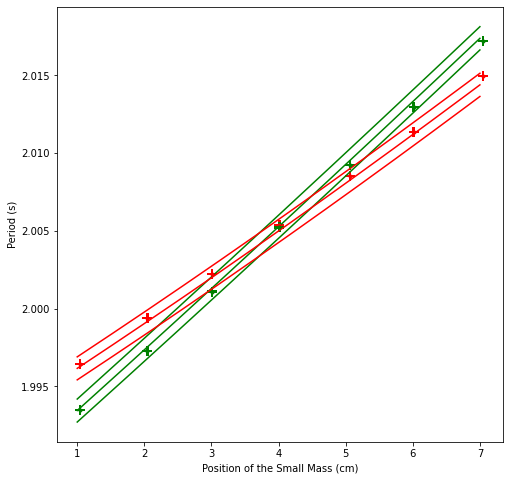

In [3]:
for i in range(1,8):
    fname1 = prefix + str(i * 2) + suffix
    fname2 = prefix + str(i * 2 - 1) + suffix

    dfup = pd.read_csv(fname1, sep='\t')
    dfdown = pd.read_csv(fname2, sep='\t')
    
    timeup = numpy.array(dfup['Time'])  
    timedown = numpy.array(dfdown['Time'])
    

    # Calculate up periods
    periodup = []
    for k in range(2,len(timeup)):
        periodup.append(timeup[k]-timeup[k-2])
    
    # Remove any outliers from the data, where an outlier is anything larger thatn Q3 + (1.5 * IQR) or less than 
    # Q1 - (1.5 * IQR). If we remove it we also have to remove the time from the list so we need to track the indicies.
    iqr = numpy.quantile(numpy.array(periodup), 0.75) - numpy.quantile(numpy.array(periodup),0.25)
    min_val = numpy.quantile(periodup,0.25) - 1.5 * iqr
    max_val = numpy.quantile(periodup,0.75) + 1.5 * iqr

    clean_vals = []
    indx_rm = []
    for idx, period in enumerate(periodup):
        if period > min_val and period < max_val:
            clean_vals.append(period)

    periodup = numpy.array(clean_vals)
    semup = periodup.std()/numpy.sqrt(len(periodup))
    tup.append(periodup.mean())
    dtup.append(semup)
    
    # Calculate down periods.
    perioddown = []
    for k in range(2,len(timedown)):
        perioddown.append(timedown[k]-timedown[k-2])
    
    # Remove any outliers from the data, where an outlier is anything larger than Q3 + (1.5 * IQR) or less than 
    # Q1 - (1.5 * IQR). If we remove it we also have to remove the time from the list so we need to track the indicies.
    iqr = numpy.quantile(numpy.array(perioddown), 0.75) - numpy.quantile(numpy.array(perioddown),0.25)
    min_val = numpy.quantile(perioddown,0.25) - 1.5 * iqr
    max_val = numpy.quantile(perioddown,0.75) + 1.5 * iqr

    clean_vals = []
    indx_rm = []
    for idx, period in enumerate(perioddown):
        if period > min_val and period < max_val:
            clean_vals.append(period)
    
    perioddown = numpy.array(clean_vals)
    semdown = perioddown.std()/numpy.sqrt(len(perioddown))
    tdown.append(perioddown.mean())
    dtdown.append(semup)

up = pd.DataFrame({'Xpos':xpos, 'Period':numpy.array(tup), 'dXpos':dxpos, 'dPeriod':numpy.array(dtup)})
down = pd.DataFrame({'Xpos':xpos, 'Period':numpy.array(tdown), 'dXpos':dxpos, 'dPeriod':numpy.array(dtdown)})

# Calculate Up regression.
init_vals = [9.814]
x = numpy.array(up['Xpos'])
y = numpy.array(up['Period'])
poptu, pcovu = curve_fit(theoryfitfunction1,x,y,p0=init_vals)

xi = numpy.linspace(1,7,1000)
ps = numpy.random.multivariate_normal(poptu,pcovu,10000)
ysample=numpy.asarray([theoryfitfunction1(xi,*pi) for pi in ps])
loweru = numpy.percentile(ysample,16.0,axis=0)
upperu = numpy.percentile(ysample,84.0,axis=0)
middleu = (loweru+upperu)/2.0
print ("Up: g = %0.4f +/- %0.4f" % (poptu[0],numpy.sqrt(pcovu[0][0])))


# Calculate Down regression
init_vals = [9.814]
x = numpy.array(down['Xpos'])
y = numpy.array(down['Period'])
poptd, pcovd = curve_fit(theoryfitfunction2,x,y,p0=init_vals)

xi = numpy.linspace(1,7,1000)
ps = numpy.random.multivariate_normal(poptd,pcovd,10000)
ysample=numpy.asarray([theoryfitfunction2(xi,*pi) for pi in ps])
lowerd = numpy.percentile(ysample,16.0,axis=0)
upperd = numpy.percentile(ysample,84.0,axis=0)
middled = (lowerd+upperd)/2.0
print ("Down: g = %0.4f +/- %0.4f" % (poptd[0],numpy.sqrt(pcovd[0][0])))

# Plot the results
plt.figure(figsize=(8,8)) 

plt.errorbar(up.Xpos,up.Period,yerr=up.dPeriod,xerr=up.dXpos,fmt='r.',capsize=5, capthick=2)
plt.errorbar(down.Xpos,down.Period,yerr=down.dPeriod,xerr=down.dXpos,fmt='g.',capsize=5, capthick=2)

plt.plot(xi,middleu, 'g')
plt.plot(xi,loweru,'g')
plt.plot(xi,upperu,'g')

plt.plot(xi,middled, 'r')
plt.plot(xi,lowerd,'r')
plt.plot(xi,upperd,'r')

plt.xlabel("Position of the Small Mass (cm)")
plt.ylabel("Period (s)")
plt.show()

To clean the data we look for outliers using quartiles. If a data point below (Q1 - 1.5 * IQR) or above (Q3 - 1.5 * IQR) then we can remove this value as a likely outlier.

According to Wolfram alpha the acceleration due to gravity in Newport News (where I assume this experiment was conducted) is 9.79893 m/s<sup>2</sup>. To get that acceleration, within errors based on the data that we have, we have to introduce a "fudge factor" of 0.00292, which is 2.92mm. While this seems like a small value, it probably is unrealisic in terms of this experiment as distances were measured with calipers.